## Примечание

В рамках данного исследования были протестированы такие подходы как pointwise, pairwise и listwise. Было построено несколько моделей с использованием следующих функций: LinearRegression, GridSearchCV, RandomForestRegressor, XGBoost, LightGBM и XGBClassifier, которая по итогу оказалась наиболее эффективной для решения поставленной задачи.

## Ход работ

### Импорт необходимых для работы библиотек

In [11]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler

### Импорт датасета и общий анализ данных

In [12]:
orig_df = pd.read_csv("intern_task.csv")

In [13]:
orig_df.head(10)

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667
2,0,10,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,...,0.0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333
3,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667
4,2,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,273.0,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000
5,1,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.200000,0.974819,22.936731,0.333333,0.033233,0.000093,28.0,9.333333
6,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,3.0,16.200000,0.000000,0.945281,18.240926,0.000000,0.013008,0.000023,5.0,1.666667
7,0,10,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
8,0,10,2.0,0.0,1.0,0.0,2.0,0.666667,0.0,0.333333,...,218.0,55.069946,0.000000,0.448807,4.695805,0.000000,0.002153,0.000002,5.0,1.666667
9,0,10,3.0,0.0,0.0,0.0,3.0,1.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.975608,0.000000,0.000000,0.021583,0.000040,9.0,3.000000


In [14]:
orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235258 entries, 0 to 235257
Columns: 146 entries, rank to feature_143
dtypes: float64(140), int64(6)
memory usage: 262.1 MB


In [15]:
orig_df.columns

Index(['rank', 'query_id', 'feature_0', 'feature_1', 'feature_2', 'feature_3',
       'feature_4', 'feature_5', 'feature_6', 'feature_7',
       ...
       'feature_134', 'feature_135', 'feature_136', 'feature_137',
       'feature_138', 'feature_139', 'feature_140', 'feature_141',
       'feature_142', 'feature_143'],
      dtype='object', length=146)

In [16]:
orig_df.dtypes

rank             int64
query_id         int64
feature_0      float64
feature_1      float64
feature_2      float64
                ...   
feature_139    float64
feature_140    float64
feature_141    float64
feature_142    float64
feature_143    float64
Length: 146, dtype: object

In [17]:
orig_df.describe(include="all")

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
count,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,...,2.352580e+05,2.352580e+05,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000
mean,0.677869,14828.413401,1.911960,0.206233,1.189847,0.550272,1.960082,0.803964,0.097557,0.541174,...,4.763432e+02,1.046698e+04,0.070299,0.740710,11.067947,0.281747,0.027033,0.000269,22.457910,9.560379
std,0.830033,8193.945170,1.237374,0.579089,1.037233,0.790947,1.203534,0.339955,0.266035,0.419973,...,1.954840e+04,2.649584e+06,0.100721,0.352800,15.336861,0.392089,0.033351,0.002088,63.708018,14.347378
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8215.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.666667,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.620522,0.000000,0.000000,0.006703,0.000000,4.000000,2.000000
50%,0.000000,14935.000000,2.000000,0.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.500000,...,0.000000e+00,0.000000e+00,0.000000,0.926779,9.448900,0.000000,0.017761,0.000008,12.000000,5.500000
75%,1.000000,21580.000000,3.000000,0.000000,2.000000,1.000000,3.000000,1.000000,0.000000,1.000000,...,1.000000e+00,4.000000e-01,0.142857,0.999613,16.146733,0.500000,0.034954,0.000109,28.000000,12.000000
max,4.000000,29995.000000,31.000000,18.000000,27.000000,9.000000,31.000000,1.000000,1.000000,1.000000,...,1.731553e+06,8.000000e+08,0.818182,1.000000,2506.799764,1.000000,0.711261,0.250000,15074.000000,1552.000000


### Проверка датафрейма на наличие пропущенных значений

In [18]:
missing_data = orig_df.isnull()
null_counts = orig_df.isnull().sum()
with pd.option_context('display.max_rows', None):
    print(null_counts)

rank           0
query_id       0
feature_0      0
feature_1      0
feature_2      0
feature_3      0
feature_4      0
feature_5      0
feature_6      0
feature_7      0
feature_8      0
feature_9      0
feature_10     0
feature_11     0
feature_12     0
feature_13     0
feature_14     0
feature_15     0
feature_16     0
feature_17     0
feature_18     0
feature_19     0
feature_20     0
feature_21     0
feature_22     0
feature_23     0
feature_24     0
feature_25     0
feature_26     0
feature_27     0
feature_28     0
feature_29     0
feature_30     0
feature_31     0
feature_32     0
feature_33     0
feature_34     0
feature_35     0
feature_36     0
feature_37     0
feature_38     0
feature_39     0
feature_40     0
feature_41     0
feature_42     0
feature_43     0
feature_44     0
feature_45     0
feature_46     0
feature_47     0
feature_48     0
feature_49     0
feature_50     0
feature_51     0
feature_52     0
feature_53     0
feature_54     0
feature_55     0
feature_56    

### Удаление id_query, с которыми связан только один документ, так как это не поможет в построении модели для ранжирования

In [19]:
document_counts = orig_df['query_id'].value_counts()
single_document_queries = document_counts[document_counts == 1].index
filtered_df = orig_df[~orig_df['query_id'].isin(single_document_queries)]

### Обнаружение аномалий в данных

In [20]:
def detect_outliers_iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (df < lower_bound) | (df > upper_bound)

features_df = filtered_df.iloc[:, 2:]

outliers = detect_outliers_iqr(features_df)

print("Количество выбросов по признакам:")
print(outliers.sum())

features_with_outliers = outliers.any()
print("\nПризнаки с выбросами:")
print(features_with_outliers[features_with_outliers].index.tolist())

Количество выбросов по признакам:
feature_0        731
feature_1      32236
feature_2        182
feature_3       5981
feature_4        742
               ...  
feature_139        0
feature_140    14615
feature_141    34769
feature_142    16473
feature_143    16493
Length: 144, dtype: int64

Признаки с выбросами:
['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51', 'feature_52', 'featur

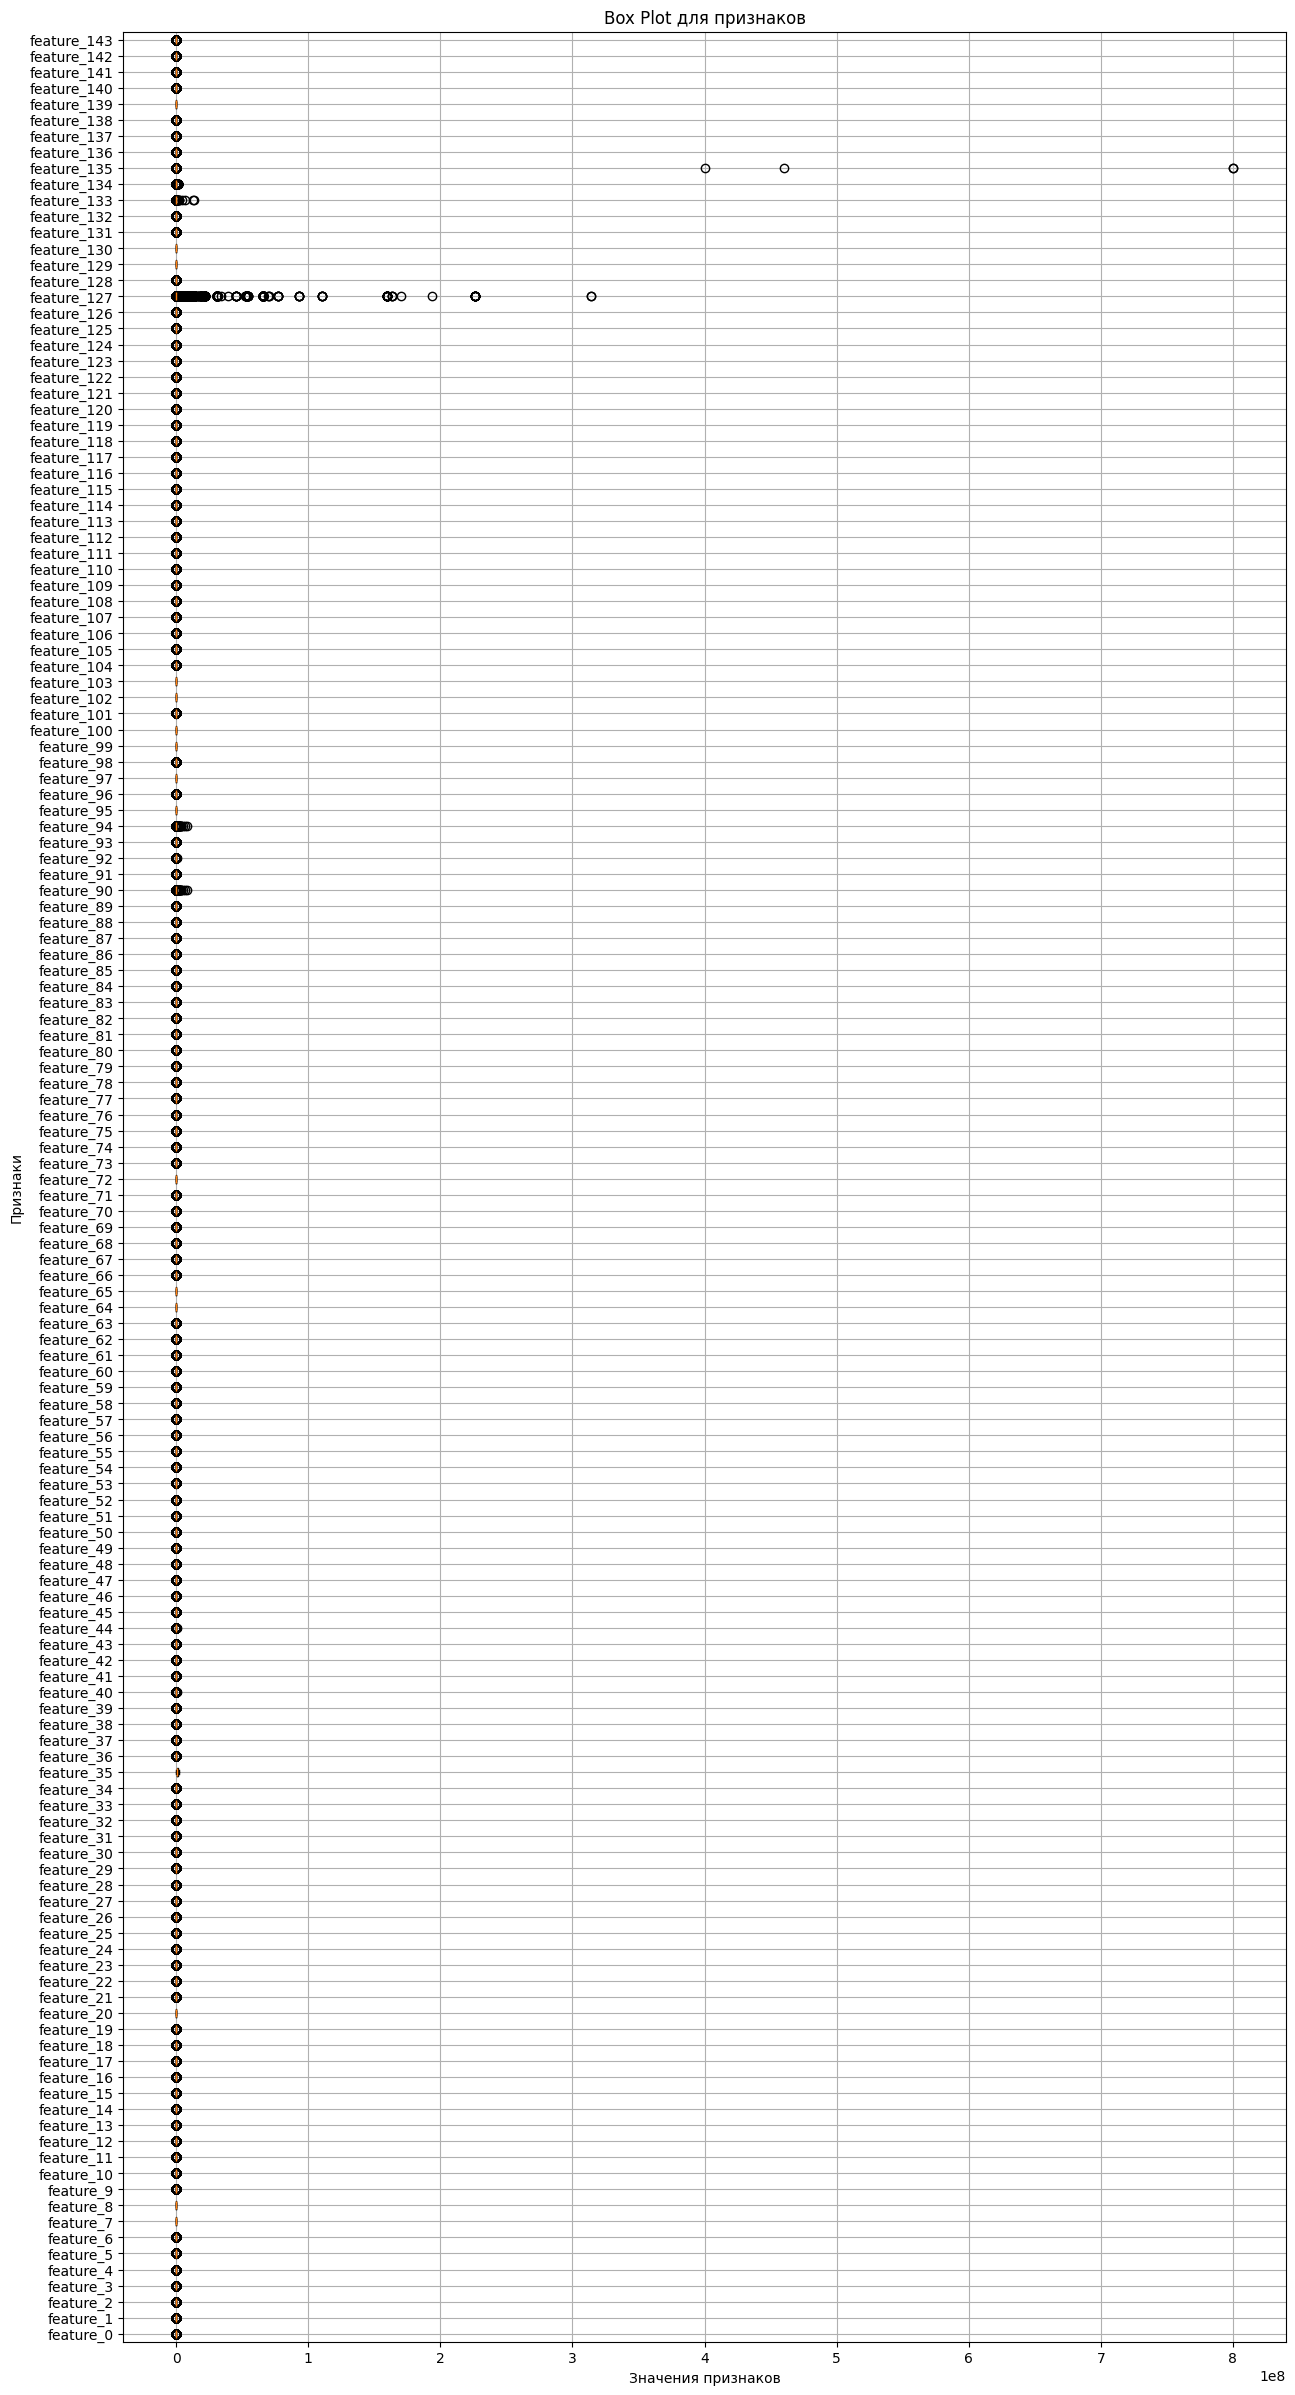

In [21]:
plt.figure(figsize=(15, 30))
plt.boxplot(filtered_df.iloc[:, 2:], vert=False)
plt.title('Box Plot для признаков')
plt.xlabel('Значения признаков')
plt.ylabel('Признаки')
plt.yticks(np.arange(1, len(filtered_df.columns[2:]) + 1), filtered_df.columns[2:])
plt.grid(True)
plt.show()

### Удаление выбросов

In [22]:
def replace_outliers_with_median(df):
    df_copy = df.copy()
    for column in df.columns:
       
        median = df_copy[column].median()
        Q1 = df_copy[column].quantile(0.25)
        Q3 = df_copy[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_copy.loc[(df_copy[column] < lower_bound) | (df_copy[column] > upper_bound), column] = median
    
    return df_copy

filtered_df = replace_outliers_with_median(filtered_df)

### Пробразование данных для начала обучения модели

In [23]:
feats_num = 143
rows_num = len(filtered_df)

# Создание словаря для хранения информации о запросах
queries_lines_info = defaultdict(list)

# Создание матрицы данных
data = np.zeros((rows_num, feats_num), dtype=np.float32)

# Создание вектора с оценками релевантности
labels = []

# Итерация по строкам датафрейма для сбора информации о запросах и создания матрицы данных
for i, row in enumerate(filtered_df.itertuples(), 0):
    query_id = getattr(row, 'query_id')
    rank = getattr(row, 'rank')
    features = [getattr(row, f'feature_{j}') for j in range(0, feats_num)]

    # Добавление информации о запросе в словарь
    queries_lines_info[query_id].append(i)

    # Заполнение матрицы данными
    data[i] = features

    # Добавление оценки релевантности в вектор
    labels.append(rank)

# Преобразование словаря векторов запросов в формат, содержащий номера строк
queries_lines_info = {query_id: [i for i in range(len(data)) if i in queries_lines_info[query_id]] for query_id in queries_lines_info}

# Преобразование вектора с оценками релевантности в numpy массив
labels = np.array(labels, dtype=np.float32)

# Удаляем строки с пропущенными метками из исходного датафрейма
df_cleaned = filtered_df.dropna(subset=['rank'])

# Определение количества признаков и строк в очищенном датафрейме
rows_num_cleaned = len(df_cleaned)

# Создание матрицы данных
data_cleaned = np.zeros((rows_num_cleaned, feats_num), dtype=np.float32)

# Создание вектора с оценками релевантности
labels_cleaned = np.zeros(rows_num_cleaned, dtype=np.float32)

# Итерация по строкам очищенного датафрейма для создания матрицы данных и вектора меток
for i, row in enumerate(df_cleaned.itertuples(), 0):
    rank = getattr(row, 'rank')

    features = [getattr(row, f'feature_{j}') for j in range(0, feats_num)]

    # Заполнение матрицы данными
    data_cleaned[i] = features

    # Добавление оценки релевантности в вектор
    labels_cleaned[i] = rank

# Разбиение очищенных данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(data_cleaned, labels_cleaned, test_size=0.2, random_state=42)

# Проверка размерностей данных
assert X_train.shape[0] + X_test.shape[0] == rows_num_cleaned

print("Тренировочные данные:", X_train.shape)
print("Тренировочные метки:", y_train.shape)
print("Тестовые данные:", X_test.shape)
print("Тестовые метки:", y_test.shape)

Тренировочные данные: (188204, 143)
Тренировочные метки: (188204,)
Тестовые данные: (47051, 143)
Тестовые метки: (47051,)


### Балансировка классов

In [24]:
# Создание словаря для хранения сбалансированных данных для каждого query_id
balanced_data = defaultdict(list)

# Применение балансировки классов к каждому поднабору данных для каждого query_id
for query_id, indices in queries_lines_info.items():
    X_query = data_cleaned[indices]
    y_query = labels_cleaned[indices]

    # Применение балансировки классов к текущему поднабору данных
    X_query_resampled, y_query_resampled = resample(X_query, y_query, random_state=42)

    # Добавление сбалансированных данных в словарь
    balanced_data[query_id] = (X_query_resampled, y_query_resampled)

# Объединение всех сбалансированных данных в единые массивы
X_balanced = np.concatenate([X for X, _ in balanced_data.values()])
y_balanced = np.concatenate([y for _, y in balanced_data.values()])

# Разбиение сбалансированных данных на тренировочный и тестовый наборы
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Проверка размерностей сбалансированных данных
assert X_train_balanced.shape[0] + X_test_balanced.shape[0] == len(X_balanced)

print("Сбалансированные тренировочные данные:", X_train_balanced.shape)
print("Сбалансированные тренировочные метки:", y_train_balanced.shape)
print("Сбалансированные тестовые данные:", X_test_balanced.shape)
print("Сбалансированные тестовые метки:", y_test_balanced.shape)

Сбалансированные тренировочные данные: (188204, 143)
Сбалансированные тренировочные метки: (188204,)
Сбалансированные тестовые данные: (47051, 143)
Сбалансированные тестовые метки: (47051,)


### Нормализация данных

In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test_balanced)

### Подбор оптимальных гиперпараметров модели

In [26]:
# Сетка параметров для перебора
param_grid = {
    'n_estimators': [500, 600, 700, 800],
    'max_depth': [5, 6, 7, 8]
}

grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, cv=3)

grid_search.fit(X_train_scaled, y_train_balanced)

best_params = grid_search.best_params_

print("Best Parameters:", best_params)

KeyboardInterrupt: 

### Запуск обучения модели

In [27]:
# Создание и обучение новой модели XGBoost с лучшими параметрами
best_model = XGBClassifier(max_depth=10, n_estimators=700)
best_model.fit(X_train_scaled, y_train_balanced)

y_pred_best = best_model.predict(X_test_scaled)

# Оценка производительности новой модели
accuracy_best = accuracy_score(y_test_balanced, y_pred_best)
report_best = classification_report(y_test_balanced, y_pred_best)

print("Accuracy with best parameters:", accuracy_best)
print("Classification Report with best parameters:")
print(report_best)

Accuracy with best parameters: 0.8273150411255872
Classification Report with best parameters:
              precision    recall  f1-score   support

         0.0       0.84      0.91      0.88     25502
         1.0       0.79      0.76      0.77     15047
         2.0       0.86      0.65      0.74      6502

    accuracy                           0.83     47051
   macro avg       0.83      0.77      0.80     47051
weighted avg       0.83      0.83      0.82     47051



### Оценка производительности модели

In [29]:
# Получение оценок вероятностей принадлежности к каждому классу
y_prob_best = best_model.predict_proba(X_test_scaled)


# Преобразование меток в формат многоклассовой метки
y_true_multiclass = label_binarize(y_test_balanced, classes=np.unique(y_test_balanced))

# Расчет NDCG@5
ndcg_5 = ndcg_score(y_true=y_true_multiclass, y_score=y_prob_best, k=5)
print("ndcg_5 score:", ndcg_5)

ndcg_5 score: 0.929215707471
